In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("FPA-FOD_39attributes.csv", low_memory = False)

unknown_mask = df['NWCG_GENERAL_CAUSE'] == "Missing data/not specified/undetermined"

df_known = df[~unknown_mask].copy()
df_unknown = df[unknown_mask].copy()
X = df_known.drop(columns=['NWCG_GENERAL_CAUSE'])
y = df_known['NWCG_GENERAL_CAUSE']



from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
le2 = LabelEncoder()
X['STATE'] = le2.fit_transform(X['STATE'])
le3 = LabelEncoder()

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y
)

X_train["Mang_Name"] = le3.fit_transform(X_train["Mang_Name"])
X_test["Mang_Name"] = le3.transform(X_test["Mang_Name"])

In [4]:
from sklearn.ensemble import RandomForestClassifier

best_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=40,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)


In [6]:
y_pred = best_rf.predict(X_test)

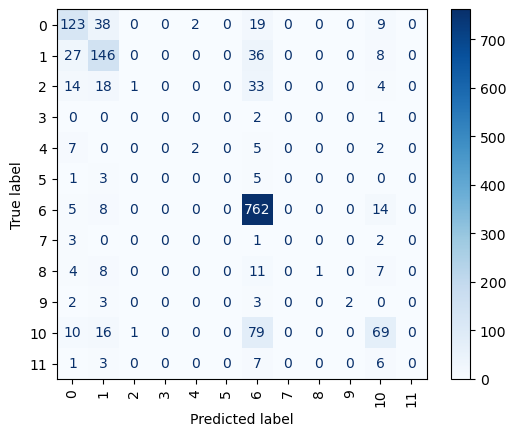

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.savefig("confusion-matrix-rf.png", dpi=400)

In [11]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, matthews_corrcoef, classification_report
)
y_true = y_test
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted') 
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Cohen’s Kappa: {kappa:.4f}")
print(f"Matthews Corr Coef: {mcc:.4f}")


Accuracy:  0.7210
Precision: 0.6890
Recall:    0.7210
F1 Score:  0.6759
Cohen’s Kappa: 0.5568
Matthews Corr Coef: 0.5673


/srv/conda/envs/notebook/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


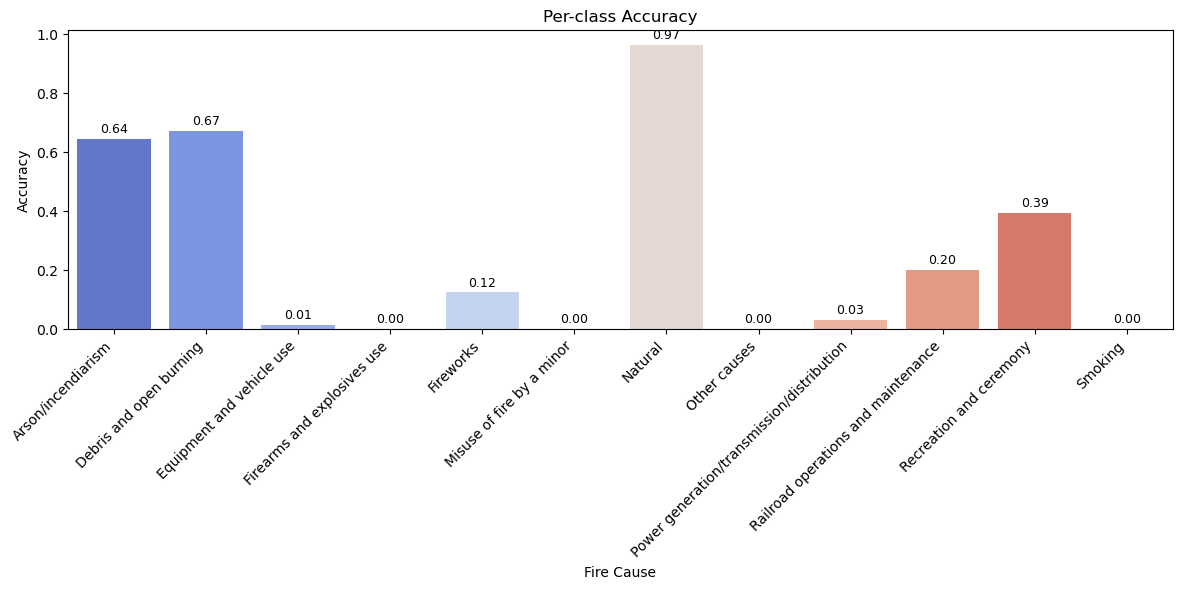

In [12]:
import seaborn as sns
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class_labels = {0:'Arson/incendiarism', 
                1:'Debris and open burning', 
                2:'Equipment and vehicle use', 
                3:'Firearms and explosives use', 
                4:'Fireworks', 
                5:'Misuse of fire by a minor', 
                6:'Natural', 
                7:'Other causes', 
                8:'Power generation/transmission/distribution', 
                9:'Railroad operations and maintenance', 
                10:'Recreation and ceremony', 
                11:'Smoking'}

classes = sorted(class_labels.keys())
class_acc = []

for c in classes:
    mask = (y_test == c)
    if mask.sum() > 0: 
        class_acc.append(accuracy_score(y_test[mask], y_pred[mask]))
    else:
        class_acc.append(np.nan)

plt.figure(figsize=(12, 6))
bars = sns.barplot(x=[class_labels[c] for c in classes], y=class_acc, palette='coolwarm', hue=[class_labels[c] for c in classes],legend=False)
plt.title('Per-class Accuracy')
plt.xlabel('Fire Cause')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')

for bar, acc in zip(bars.patches, class_acc):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{acc:.2f}', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("per-class-rf.png", dpi=400)
plt.show()


In [13]:
import numpy as np

natural_idx = 6
y_binary_true = (y_test == natural_idx).astype(int)  
y_binary_pred = (y_pred == natural_idx).astype(int)

# Binary CM: [[TN, FP], [FN, TP]]
cm_binary = confusion_matrix(y_binary_true, y_binary_pred)

# Metrics
binary_accuracy = accuracy_score(y_binary_true, y_binary_pred)
precision_natural = precision_score(y_binary_true, y_binary_pred)
recall_natural = recall_score(y_binary_true, y_binary_pred)
f1_natural = f1_score(y_binary_true, y_binary_pred)

print("Binary CM (Human vs Natural):\n", cm_binary)
print(f"Binary Accuracy: {binary_accuracy:.1%}")
print(f"Natural Precision: {precision_natural:.1%}")
print(f"Natural Recall: {recall_natural:.1%}")
print(f"Natural F1: {f1_natural:.1%}")

Binary CM (Human vs Natural):
 [[544 201]
 [ 27 762]]
Binary Accuracy: 85.1%
Natural Precision: 79.1%
Natural Recall: 96.6%
Natural F1: 87.0%
